In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()


2020-12-06 10:59:35,734 - PySpice.Spice.Netlist.__new__ - DEBUG - Element don't define a __pins__ attribute
2020-12-06 10:59:35,736 - PySpice.Spice.Netlist.__new__ - DEBUG - FixedPinElement don't define a __pins__ attribute
2020-12-06 10:59:35,741 - PySpice.Spice.Netlist.__new__ - DEBUG - SubCircuitElement don't define a __pins__ attribute
2020-12-06 10:59:35,743 - PySpice.Spice.Netlist.__new__ - DEBUG - Resistor don't define a __pins__ attribute
2020-12-06 10:59:35,746 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorResistor don't define a __pins__ attribute
2020-12-06 10:59:35,750 - PySpice.Spice.Netlist.__new__ - DEBUG - BehavioralResistor don't define a __pins__ attribute
2020-12-06 10:59:35,756 - PySpice.Spice.Netlist.__new__ - DEBUG - Capacitor don't define a __pins__ attribute
2020-12-06 10:59:35,759 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorCapacitor don't define a __pins__ attribute
2020-12-06 10:59:35,763 - PySpice.Spice.Netlist.__new__ - DEBUG - Behaviora

![module](https://img.shields.io/badge/module-shin%20ey-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *shin ey*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*

pegel is a voltage controlled amplifier (vca). there are various designs to implement a vca. rod elliott (ESP) has an article on vca techniques [[1][1]]. diy synthesizer modules are usualy designed with an integrated vca chip [[2][2]]  or with a differential amplifier [[3][3]]. the integrated vca chips are either obsolete or rather expensive. the differential amplifier can be built with transistors only. the design has some downsides. even in the simulation the result is not symetryc and has a dc offset from the control voltage. this needs a lot of trimming to get an accurate result. but the biggest downside is, that this design can not do proper amplitude modulation (am). when the carrier signal goes below zero the base signal is completely muted. 

### input mixer

this  is  a pasive input mixer.


In [2]:
from sympy import symbols, sqrt, exp, diff, integrate, pprint, simplify, Eq, preview, pi, solve

from sympy import init_printing
#init_printing(use_latex='mathml')

R, C, fc = symbols('R,C,fc', real=True)
lp_f = 1 / ( 2 * pi * R * C)
Eq( lp_f, fc)


Eq(1/(2*pi*C*R), fc)

In [3]:
R1, R2, C1, C2, fc = symbols('R1,R2,C1,C2,fc')
lp_f = 1 / ( 2 * pi * sqrt(R1 * R2 * C1 * C2))

Eq(fc, lp_f)


Eq(fc, 1/(2*pi*sqrt(C1*C2*R1*R2)))

In [4]:
r1 = 10@u_kΩ
r2 = 10@u_kΩ
c1 = 0.082@u_uF
c2 = 0.082@u_uF

Eq(fc, lp_f.subs(R1, r1).subs(C1, c1).subs(R2, r2).subs(C2, c2).subs(pi,math.pi))


Eq(fc, 194.091394014506)

In [5]:
r1 = 10@u_kΩ
r2 = 10@u_kΩ
c1 = 4.7@u_nF
c2 = 4.7@u_nF

Eq(fc, lp_f.subs(R1, r1).subs(C1, c1).subs(R2, r2).subs(C2, c2).subs(pi,math.pi))

Eq(fc, 3386.27538493394)

## low pass filter


In [6]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'LowPass200.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['4069UB'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
#schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V SINE(0 5V 1k)')
schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V PULSE(-5V 5V 1u 1u 1u 2m 4m)')

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_lp_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')
analysis_lp_tr = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=120@u_ms)



2020-12-06 10:59:38,652 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance - DEBUG - New instance for id 0
2020-12-06 10:59:38,653 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._load_library - DEBUG - Set locale LC_NUMERIC to C
2020-12-06 10:59:38,741 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._load_library - DEBUG - Load library libngspice.so
2020-12-06 10:59:38,824 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stderr Error: bad type for debug var'
2020-12-06 10:59:38,827 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Error: bad type for debug var
2020-12-06 10:59:38,831 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stderr Warning: ngspice compiled without debug messages'
2020-12-06 10:59:38,833 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: ngspice compiled without debug messages
2020-12-06 10:59:38,834 - PySpice.Spice.NgSpice.Shared._send_char - DEBUG - b'stdout ******'
2020-12-06 10:59:38,839 - PySpice.Spice.N

In [7]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'HighPass4000.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['4069UB'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
#schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V SINE(0 5V 1k)')
schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V PULSE(-5V 5V 1u 1u 1u 2m 4m)')

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_hp_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')
analysis_hp_tr = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=120@u_ms)

2020-12-06 10:59:42,680 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
XU1 Net-_R1-Pad1_ Net-_C1-Pad2_ +15V GND 4069UB
XU2 Net-_C1-Pad1_ Net-_C2-Pad2_ +15V GND 4069UB
R2 Net-_C1-Pad2_ Net-_R1-Pad1_ 100k
R1 Net-_R1-Pad1_ NC_01 100k
C3 /OUT Net-_C3-Pad2_ 10u
R6 GND /OUT 1k
R4 Net-_C2-Pad2_ Net-_C1-Pad1_ 10k
XU3 Net-_C2-Pad1_ Net-_C3-Pad2_ +15V GND 4069UB
C2 Net-_C2-Pad1_ Net-_C2-Pad2_ 4.7n
R7 Net-_C3-Pad2_ Net-_C2-Pad1_ 10k
R8 Net-_C3-Pad2_ Net-_R1-Pad1_ 100k
C1 Net-_C1-Pad1_ Net-_C1-Pad2_ 4.7n
V1 +15V 0 DC 15
V2 -15V 0 DC -15
V3 NC_01 0 DC 0V AC 5V PULSE(-5V 5V 1u 1u 1u 2m 4m)
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 10Hz 10kHz
.end

2020-12-06 10:59:42,682 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2020-12-06 10:59:42,687 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG -

In [8]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'BandPass900-4000.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['TL072'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
#schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V SINE(0 5V 1k)')
schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V PULSE(-5V 5V 1u 1u 1u 2m 4m)')

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_bp_900 = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')


2020-12-06 11:00:01,395 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/TL072.lib
XU5 Net-_C9-Pad2_ Net-_C10-Pad1_ +15V -15V Net-_C10-Pad1_ TL072
C10 Net-_C10-Pad1_ Net-_C10-Pad2_ 10n
R10 Net-_C9-Pad2_ Net-_C10-Pad2_ 15k
R9 Net-_C10-Pad2_ NC_01 15k
C9 GND Net-_C9-Pad2_ 910p
XU6 Net-_C12-Pad1_ /OUT +15V -15V /OUT TL072
C11 Net-_C11-Pad1_ Net-_C10-Pad1_ 10n
R12 /OUT Net-_C11-Pad1_ 4.7k
R11 GND Net-_C12-Pad1_ 40k
C12 Net-_C12-Pad1_ Net-_C11-Pad1_ 10n
V1 +15V 0 DC 15
V2 -15V 0 DC -15
V3 NC_01 0 DC 0V AC 5V PULSE(-5V 5V 1u 1u 1u 2m 4m)
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 10Hz 10kHz
.end

2020-12-06 11:00:01,398 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2020-12-06 11:00:01,402 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title KiCad schematic
.include /home/etien

In [9]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'bp200-900.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['4069UB'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
schema.V('3', 'NC_01', schema.gnd, 'DC 0V AC 5V SINE(0 5V 1k)')

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_bp_200 = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')

2020-12-06 11:00:01,480 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
XU3 Net-_C5-Pad2_ Net-_C6-Pad1_ +15V -15V Net-_C6-Pad1_ TL072
C6 Net-_C6-Pad1_ Net-_C6-Pad2_ 47n
R6 Net-_C5-Pad2_ Net-_C6-Pad2_ 15k
R5 Net-_C6-Pad2_ NC_01 15k
C5 GND Net-_C5-Pad2_ 4.7n
XU4 Net-_C8-Pad1_ /OUT +15V -15V /OUT TL072
C7 Net-_C7-Pad1_ Net-_C6-Pad1_ 47n
R8 /OUT Net-_C7-Pad1_ 4.7k
R7 GND Net-_C8-Pad1_ 40k
C8 Net-_C8-Pad1_ Net-_C7-Pad1_ 47n
V1 +15V 0 DC 15
V2 -15V 0 DC -15
V3 NC_01 0 DC 0V AC 5V SINE(0 5V 1k)
.options TEMP = 25C
.options TNOM = 25C
.ic 
.ac dec 10 10Hz 10kHz
.end

2020-12-06 11:00:01,482 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2020-12-06 11:00:01,490 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.load_circuit - DEBUG - ngSpice_Circ
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice

2020-12-06 11:00:01,646 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-06 11:00:01,655 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-06 11:00:01,668 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


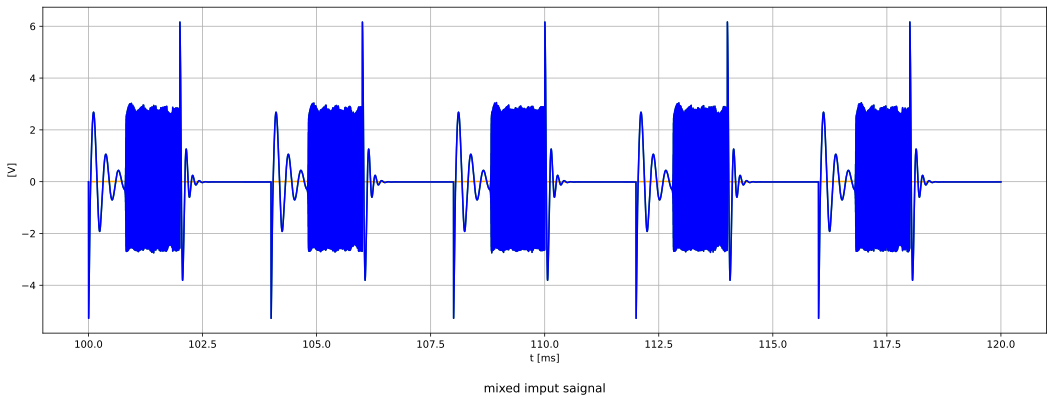

In [10]:
#plot the results
fig, axis = plt.subplots(figsize=(18, 6))

#plot mixed signal
axis.plot(analysis_lp_tr['/OUT'].abscissa*1000, analysis_lp_tr['/OUT'], c='Orange') 
axis.plot(analysis_hp_tr['/OUT'].abscissa*1000, analysis_hp_tr['/OUT'], c='Green') 
axis.plot(analysis_hp_tr['/OUT'].abscissa*1000, analysis_hp_tr['/OUT'], c='Blue') 
#axis.plot(analysis_lp_tr['Net-_R2-Pad1_'].abscissa*1000, analysis_lp_tr['Net-_R2-Pad1_'], c='Green') 
#axis.plot(analysis_lp_tr['NC_01'].abscissa*1000, analysis_lp_tr['NC_01'], c='grey') 

axis.grid()
axis.set_xlabel('t [ms]')
axis.set_ylabel('[V]')
axis.set_title('mixed imput saignal', y=-0.2)

plt.show()

2020-12-06 11:02:19,990 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2020-12-06 11:02:19,991 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2020-12-06 11:02:19,992 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2020-12-06 11:02:19,993 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'arctan2'> is FLOAT
2020-12-06 11:02:19,998 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2020-12-06 11:02:20,041 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'absolute'> is NO_CONVERSION
2020-12-06 11:02:20,043 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'log10'> is FLOAT
2020-12-06 11:02:20,051 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - WARNING - Should be unit less
2020-12-06 11:02:20,054 - PySpice.Prob

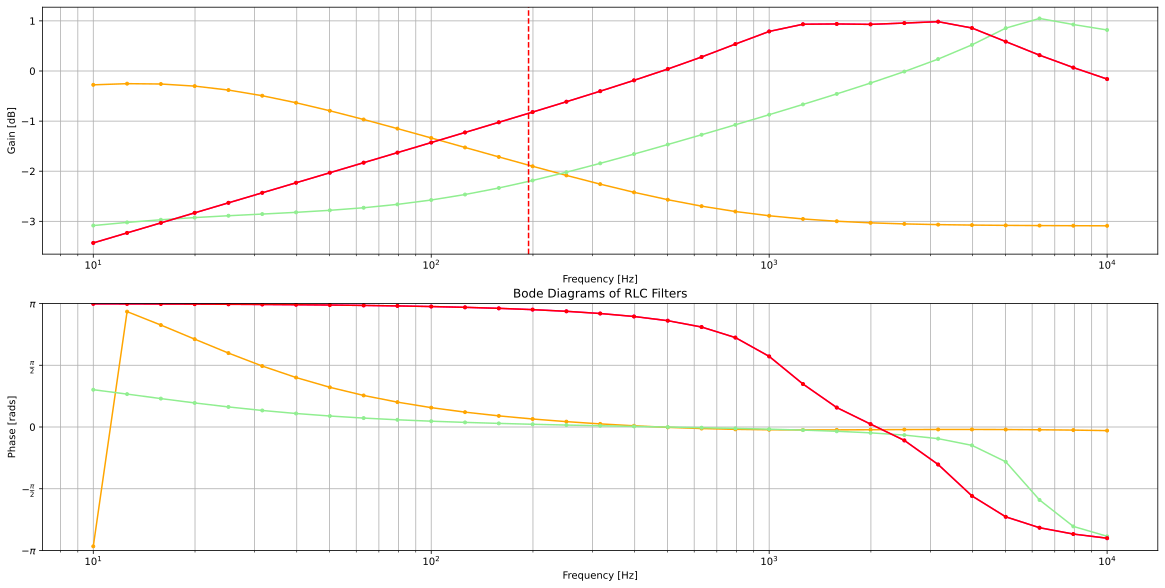

In [13]:
figure, axes = plt.subplots(2, figsize=(20, 10))
plt.title("Bode Diagrams of RLC Filters")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_lp_ac.frequency,
                 gain=np.log10(np.absolute(analysis_lp_ac['/OUT'])),
                 phase=np.angle(analysis_lp_ac['/OUT'], deg=False),
                 marker='.',
                 color='orange',
                 linestyle='-',
    )
bode_diagram(axes=axes,
                 frequency=analysis_hp_ac.frequency,
                 gain=np.log10(np.absolute(analysis_hp_ac['/OUT'])),
                 phase=np.angle(analysis_hp_ac['/OUT'], deg=False),
                 marker='.',
                 color='LightGreen',
                 linestyle='-',
    )
bode_diagram(axes=axes,
                frequency=analysis_bp_900.frequency,
                gain=np.log10(np.absolute(analysis_bp_900['/OUT'])),
                phase=np.angle(analysis_bp_900['/OUT'], deg=False),
                marker='.',
                color='Magenta',
                linestyle='-',
)
bode_diagram(axes=axes,
                frequency=analysis_bp_200.frequency,
                gain=np.log10(np.absolute(analysis_bp_200['/OUT'])),
                phase=np.angle(analysis_bp_200['/OUT'], deg=False),
                marker='.',
                color='Red',
                linestyle='-',
)
    #for axe in axes:
axes[0].axvline(x=194.091394014506, color='Red', linestyle='--')


In [12]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['BC846B'])
schema.include(spice_library['BC556B'])
schema.include(spice_library['CD4069UBhex'])
schema.include(spice_library['D1N4148'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
schema.V('3', '+5V', schema.gnd, 'DC 5')
#schema.V('4', 'INPUT', schema.gnd, 'DC 0V AC 2V PULSE(-5V +5V 0 1m 1m 0.0001m 2.0001m)')
schema.V('4', 'INPUT', schema.gnd, 'DC 0V AC 2V PULSE(-2V +2V 0 0.0001m 5m 0.0001m 5.0002m)')

class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider2(SubCircuitFactory):
    __name__ = 'voltage_divider_2'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

for subcircuit in ( VoltageDivider1(R=500@u_kΩ, w=0.999), VoltageDivider2(R=500@u_kΩ, w=0.1) ):
    schema.subcircuit(subcircuit)

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=120@u_ms)


2020-12-06 11:00:05,504 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/transistor/bc5x7.lib
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/CD4069UB-hex.lib
.include /home/etienne/Documents/elektrophon/lib/spice/diode/1N4148.mod
.subckt voltage_divider_1 n1 n2 n3
R1 n1 n2 499.5kOhm
R2 n2 n3 0.5000000000000004kOhm
.ends voltage_divider_1

.subckt voltage_divider_2 n1 n2 n3
R1 n1 n2 50.0kOhm
R2 n2 n3 450.0kOhm
.ends voltage_divider_2
XU1 Net-_C1-Pad2_ /LowPass200/OUT +15V -15V /LowPass200/OUT TL072
C2 /LowPass200/OUT Net-_C2-Pad2_ 0.082u
R2 Net-_C1-Pad2_ Net-_C2-Pad2_ 10k
R1 Net-_C2-Pad2_ NC_01 10k
C1 GND Net-_C1-Pad2_ 0.082u
V1 +15V 0 DC 15
V2 -15V 0 DC -15
V3 +5V 0 DC 5
V4 INPUT 0 DC 0V AC 2V PULSE(-2V +2V 0 0.0001m 5m 0.0001m 5.0002m)
.options TEMP = 25C
.options TNOM = 25C
.ic 
.tran 1us 120ms 100ms
.end

2020-12-06 11:00:05,506 - PySpice.Spice.NgSpice.Share

### filter sections


## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [VCA Techniques Investigated][1] Rod Elliott (ESP)
- [Popular Electronics][2] Keyiing and VCA citcuits for electronic music instruments 
- [VCA-1][3] Thomas Henry CA3080 vca
- [VCA-3][4] René Schmitz differential pair vca
- [#223][5]: Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator
- [#224][6]: AM & DSB-SC Modulation with the Gilbert Cell
- [Analog Devices][8]: Analog multiplier application guide 
- [AD633][9]: Datasheet 




[1]: https://static1.squarespace.com/static/5e6e99e8bd2f8a6de8454feb/t/5e77db16e8ff44374c24b124/1584913176675/MBD+BOM+and+build.pdf
[2]: https://www.diystompboxes.com/smfforum/index.php?topic=118397.0
[3]: https://www.diystompboxes.com/smfforum/index.php?topic=99779.0



